In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.4 MB/s eta 0:00:00


In [ ]:
import os
import timm

import csv

import torch
import torch.nn as nn

import numpy as np
import pandas as pd

import torchvision
from torchvision import tv_tensors, transforms
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision.transforms import v2 as T
from torchvision.transforms import Grayscale, ToPILImage, ToTensor
from torchvision.transforms.v2 import functional as F
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.models as models
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from skimage import exposure
from PIL import Image, ImageOps

import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
#used when image is in tensor form
def show_t(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#used when image is read with PIL
def show(img):
  # img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) solo se lette con opencv
  plt.figure(figsize=(7, 7))
  plt.imshow(img)
  plt.show()


def detection_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes,
    )

    return model

class CustomClassifierModel(nn.Module):

  def __init__(self, num_classes, model_type):
    super(CustomClassifierModel, self).__init__()
    self.model_type = model_type

    if self.model_type == 'eff':
      self.model = timm.create_model("efficientnet_b0", pretrained=True)
      in_features = self.model.classifier.in_features
      self.model.classifier = nn.Linear(in_features, num_classes)

    if self.model_type == 'resnet18':
      self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
      in_features = self.resnet.fc.in_features
      self.resnet.fc = nn.Linear(in_features, num_classes)
    if self.model_type == 'resnet50':
      self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
      in_features = self.resnet.fc.in_features
      self.resnet.fc = nn.Linear(in_features, num_classes)
    if self.model_type == 'vgg16':
      self.model = models.vgg16(weights=models.VGG16_Weights.DEFAULT) #pretrained=True
      self.model.classifier[6] = nn.Linear(4096, num_classes)

    # in_features = self.model.classifier.in_features
    # self.model.classifier = nn.Linear(in_features, num_classes)

  def forward(self, x):
    if self.model_type == 'resnet18': return self.resnet(x)
    if self.model_type == 'resnet50': return self.resnet(x)
    if self.model_type == 'eff': return self.model(x)
    if self.model_type == 'vgg16': return self.model(x)

# Load models


In [ ]:
path_detection_model = '/content/drive/MyDrive/VISIOPE_Project/weights/MaskRCNN_10epochs_4batch_onlytaco'
path_classification_model = '/content/drive/MyDrive/VISIOPE_Project/weights/pesi_classification/4_ep_vgg_64b_FIX_SETS_bal_lr.pth'

#load of detection model with our weights
detection_model = detection_model(2)
detection_model.load_state_dict(torch.load(path_detection_model))
detection_model.to(device)
detection_model.eval()

#load of classification model with our weights
classification_model = CustomClassifierModel(6, 'vgg16')
classification_model.load_state_dict(torch.load(path_classification_model))
classification_model.to(device)
classification_model.eval()

# Inference

In [ ]:
dict_label = {0 : 'biodegradable', 1 : 'glass', 2 : 'paper', 3 : 'plastic', 4 : 'special', 5 : 'trash'}

#this function is called for each image
def draw_mask_on_image(output_det, image):

  #list of predicted mask of single image
  pred_masks = []

  for pred_mask, score in zip(output_det["masks"], output_det["scores"]):
    #choose trashold to accept or discard a detection
    if score >= 0.8:
      #choose trashold to accept or discard a single pixel in a mask
      bool_pixel = pred_mask > 0.3
      pred_masks.append(bool_pixel)

  print('IDENTIFIED OBJECTS: ', len(pred_masks))

  if len(pred_masks) == 0: return []

  #tensor of masks from the predicted masks' list
  masks = torch.stack(pred_masks)

  image_ret = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
  image_ret = image_ret[:3, ...]

  #return image with a segmentantion draw on top of original image
  image_seg = draw_segmentation_masks(image_ret.to(torch.uint8), masks.squeeze(1), alpha = 0.5, colors = 'red')

  #show image
  show_t(image_seg)

  return image_seg


#this function is called for each image
def extrapolation_bbox(pred_image, image):

  pred_boxes = []
  pred_labels = []
  for label, box, score in zip(pred_image["labels"], pred_image["boxes"], pred_image["scores"]):
    #choose trashold to accept or discard a detection
    if score >= 0.8:
      pred_boxes.append(box.long())
      pred_labels.append(f"trash: {score:.3f}")

  if len(pred_boxes) == 0: return []
  boxes = torch.stack(pred_boxes)

  image_ret = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
  image_ret = image_ret[:3, ...]

  #return image with a bounded box draw on top of original image
  output_image = draw_bounding_boxes(image_ret, boxes, pred_labels, colors="red")

  #show image
  show_t(output_image)

  #return the value of the boxes (1 or more values)
  return boxes

In [ ]:
transform = transforms.Compose([
  transforms.Resize((128, 128)),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

tra = transforms.ToTensor()

## PERFORM INFERENCE ON CSV TEST-SET

In [ ]:
#path of csv with images test
test_image_path = '/content/drive/MyDrive/VISIOPE_Project/DATASET/trash_ICRA19/'

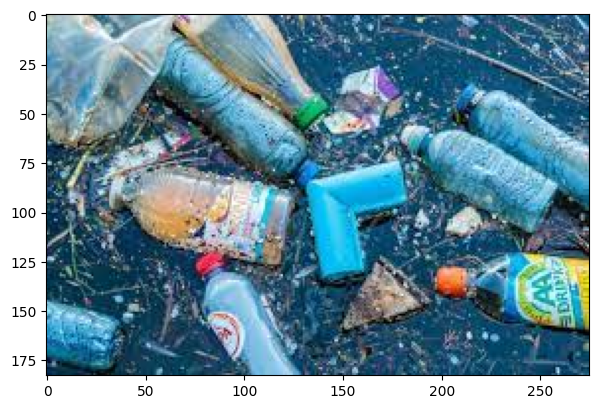

IDENTIFIED OBJECTS:  3
/content/drive/MyDrive/VISIOPE_Project/DATASET/Test4.jpg
THE NET PREDICTS biodegradable
TRUE biodegradable
/content/drive/MyDrive/VISIOPE_Project/DATASET/Test4.jpg
THE NET PREDICTS paper
TRUE biodegradable
/content/drive/MyDrive/VISIOPE_Project/DATASET/Test4.jpg
THE NET PREDICTS biodegradable
TRUE biodegradable


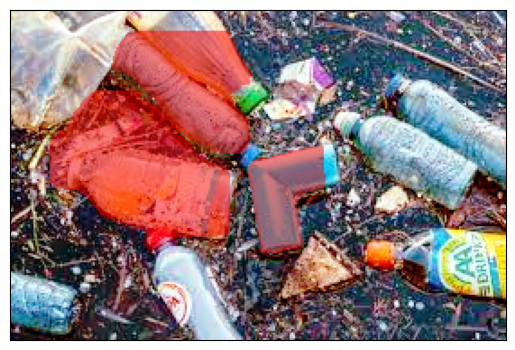

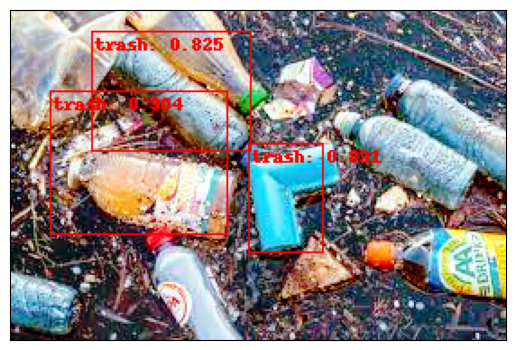

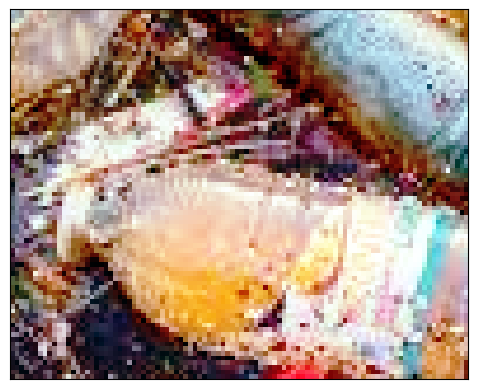

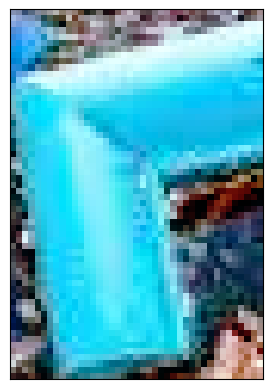

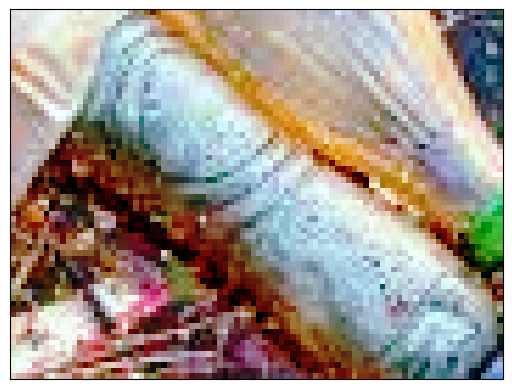

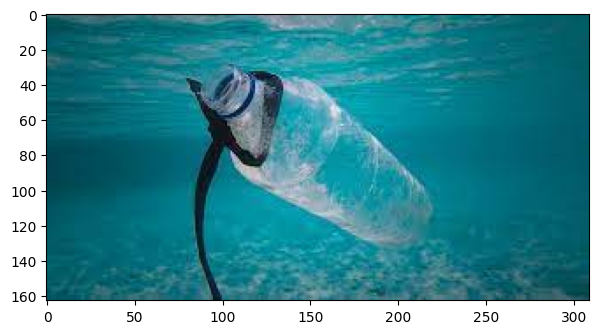

IDENTIFIED OBJECTS:  1
/content/drive/MyDrive/VISIOPE_Project/DATASET/Test5.jpg
THE NET PREDICTS trash
TRUE biodegradable


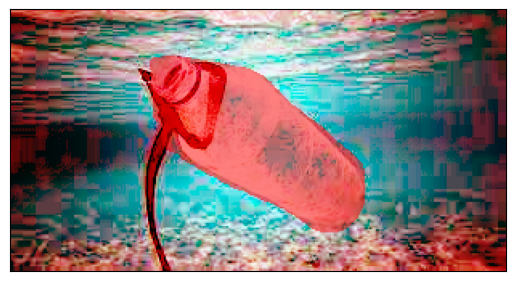

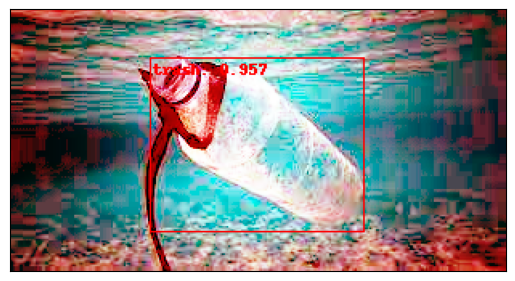

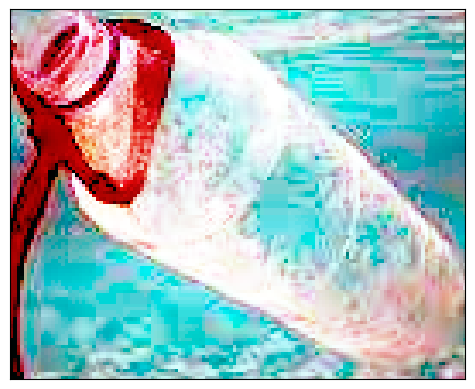

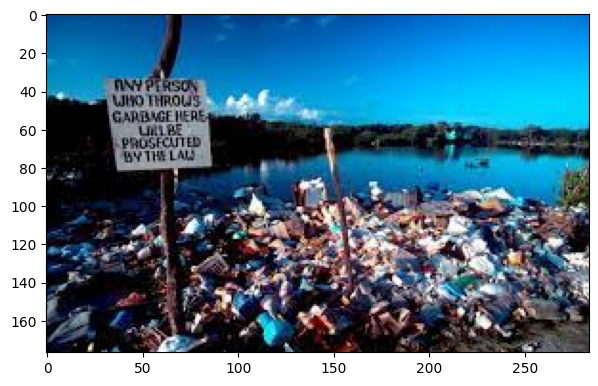

IDENTIFIED OBJECTS:  0
NO IMAGE DETECTION


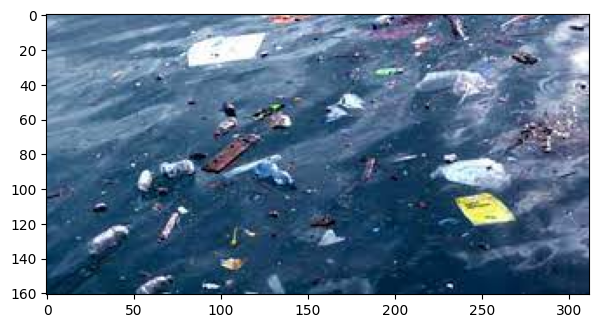

IDENTIFIED OBJECTS:  0
NO IMAGE DETECTION


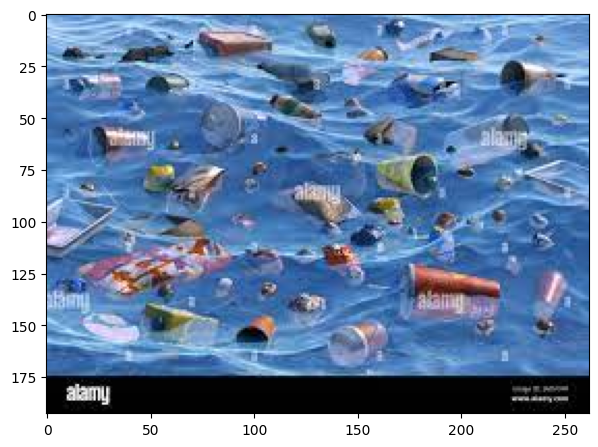

IDENTIFIED OBJECTS:  3
/content/drive/MyDrive/VISIOPE_Project/DATASET/Test8.jpg
THE NET PREDICTS biodegradable
TRUE biodegradable
/content/drive/MyDrive/VISIOPE_Project/DATASET/Test8.jpg
THE NET PREDICTS biodegradable
TRUE biodegradable
/content/drive/MyDrive/VISIOPE_Project/DATASET/Test8.jpg
THE NET PREDICTS biodegradable
TRUE biodegradable


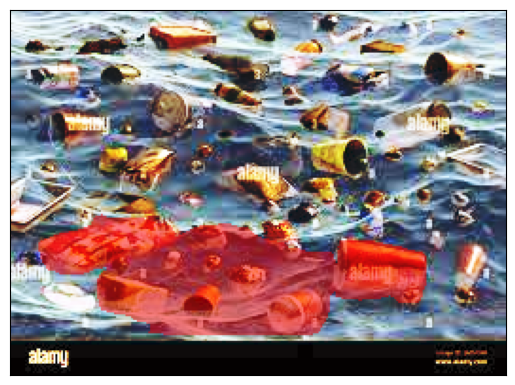

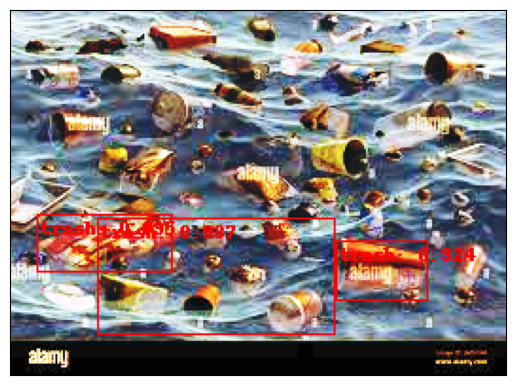

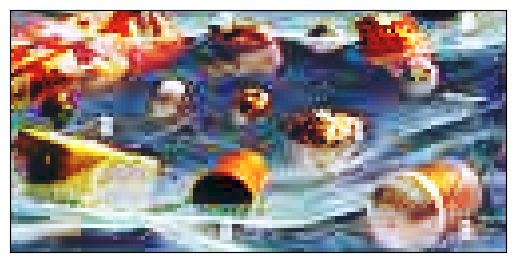

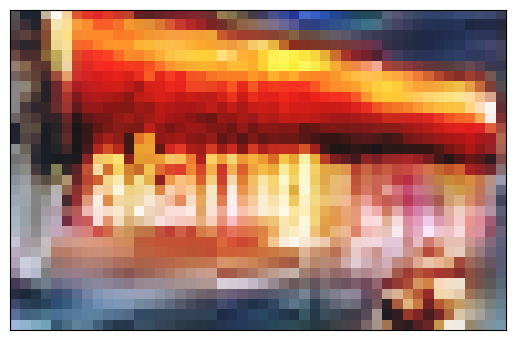

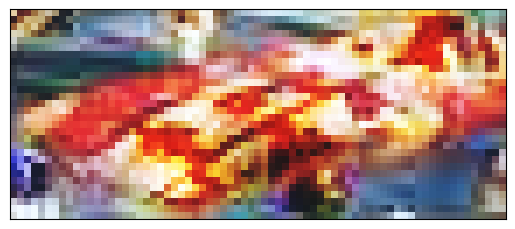

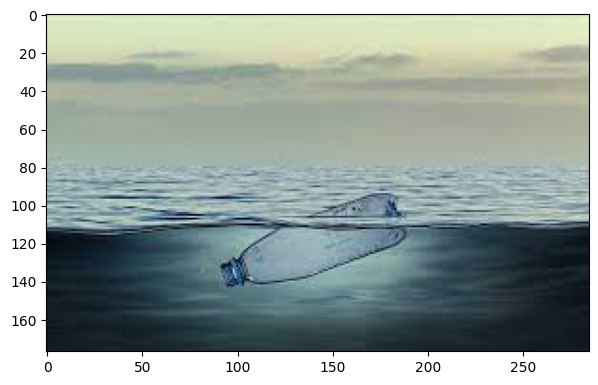

IDENTIFIED OBJECTS:  0
NO IMAGE DETECTION


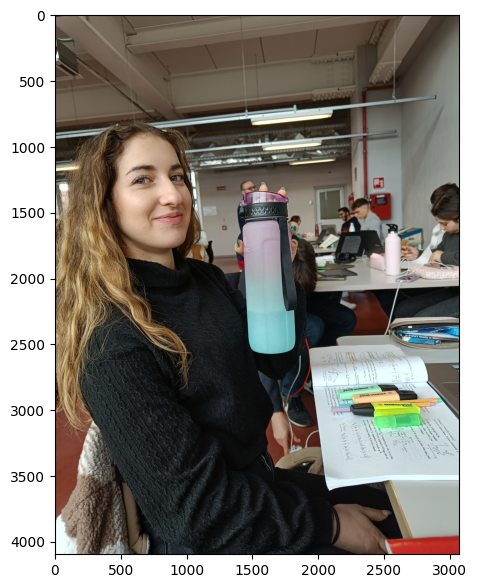

IDENTIFIED OBJECTS:  3
/content/drive/MyDrive/VISIOPE_Project/DATASET/alessia.jpg
THE NET PREDICTS plastic
TRUE biodegradable
/content/drive/MyDrive/VISIOPE_Project/DATASET/alessia.jpg
THE NET PREDICTS paper
TRUE biodegradable
/content/drive/MyDrive/VISIOPE_Project/DATASET/alessia.jpg
THE NET PREDICTS trash
TRUE biodegradable


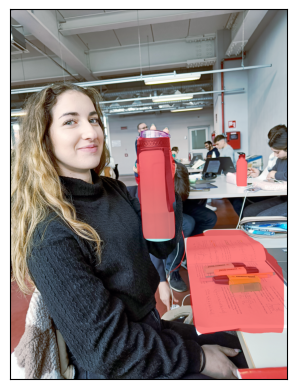

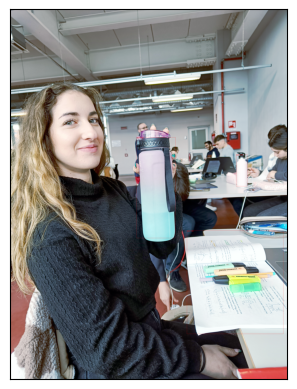

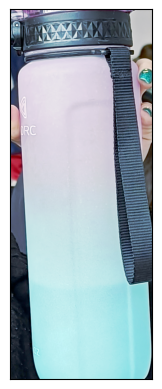

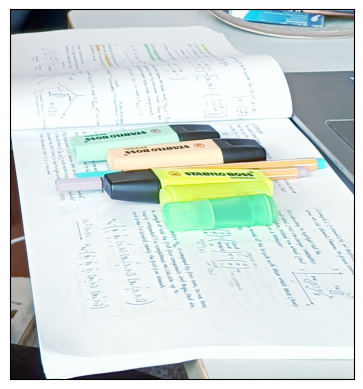

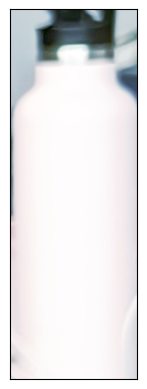

In [ ]:
# DETECTION OBJECT --> LIST CROPPED IMAGE
# CLASSIFICATION OBJECT

data_dir_path = '/content/drive/MyDrive/VISIOPE_Project/DATASET/'
csv_TEST_path = data_dir_path+'test_class.csv'

def applicativo(path_csv = None, detection_model, classification_model):

  df_test = pd.read_csv(path_csv)

  for i in range(len(df_test)):

    img_path = df_test.iloc[i, 0]

    label = int(df_test.iloc[i, 1])   # LABEL ARE IN 4TH POSITION IN TACO CSV

    ## START DETECTION PART

    image = Image.open(img_path).convert("RGB")
    show(image)
    image_cont = ImageOps.equalize(image)

    image_g = tra(image_cont)
    t_image = image_g.unsqueeze(0).float().to(device)

    pred_img = detection_model(t_image[:, :3, :, :])

    image_seg = draw_mask_on_image(pred_img[0], image_g)
    if image_seg == []:
      print('NO IMAGE DETECTION')
      continue

    crop_regions = extrapolation_bbox(pred_img[0], image_g)
    if crop_regions == []:
      print('NO IMAGE DETECTION')
      continue

    ## START CLASSIFICATION PART

    for region in crop_regions:
      left, top, right, bottom = region
      cropped_image = image_g[:, top:bottom, left:right]

      #to classify the image we use the same image transformation that we used during training phase
      class_image = transform(cropped_image[ :3, :, :])
      x = class_image.unsqueeze(0).to(device)


      outputs = classification_model(x.float())
      _, predicted = torch.max(outputs.data, 1)
      predicted = predicted.cpu()

      #if label != predicted[0].item():

      # Show cropped image
      show_t(cropped_image)

      print(img_path)
      print('THE NET PREDICTS', dict_label[predicted[0].item()])
      print('TRUE', dict_label[label])


applicativo(csv_TEST_path, detection_model, classification_model)

## INFERENCE ON ONE "NEW" IMAGE

In [ ]:
img_path = test_image_path+''

## START DETECTION PART

image = Image.open(img_path).convert("RGB")
show(image)
image_cont = ImageOps.equalize(image)

image_g = tra(image_cont)
t_image = image_g.unsqueeze(0).float().to(device)
pred_img = detection_model(t_image[:, :3, :, :])


image_seg = draw_mask_on_image(pred_img[0], image_g)
if image_seg == []:
  print('NO IMAGE DETECTION')
  continue

crop_regions = extrapolation_bbox(pred_img[0], image_g)
if crop_regions == []:
  print('NO IMAGE DETECTION')
  continue

## START CLASSIFICATION PART

for region in crop_regions:
  left, top, right, bottom = region
  cropped_image = image_g[:, top:bottom, left:right]

  #to classify the image we use the same image transformation that we used during training phase
  class_image = transform(cropped_image[ :3, :, :])
  x = class_image.unsqueeze(0).to(device)

  outputs = classification_model(x.float())
  _, predicted = torch.max(outputs.data, 1)
  predicted = predicted.cpu()

  # Show cropped image
  show_t(cropped_image)

  print(img_path)
  print('THE NET PREDICTS', dict_label[predicted[0].item()])

# Detection sul dataset della classificazione

Fare un for sulle immagini del dataset, leggendo i csv, e salvarli nelle relative cartelle

In [ ]:
# Specify the file name
root_dir = '/content/drive/MyDrive/VISIOPE_Project/DATASET/CLASSIFICATION_dataset/'
csv_file_name = ['test_class.csv']

for file_name in csv_file_name:
  # Open the CSV file in read mode
  with open(root_dir+file_name, 'r', newline='') as csvfile:
      # Create a CSV reader object
      csv_reader = csv.reader(csvfile)
      for row in csv_reader:
        #print(row)
        #print(root_dir+row[0])

        img_path = root_dir+row[0]
        label  = dict_label[int(row[1])]

        img = cv2.imread(img_path)

        image_g = tra(img)
        #print(image_g.size())
        t_image = image_g.unsqueeze(0).float().to(device)

        pred_img = detection_model(t_image[:, :3, :, :])

        crop_regions = extrapolation_bbox(pred_img[0], image_g)

        if crop_regions == [] or len(crop_regions) > 1:
          print('NO IMAGE DETECTION OR TOO MUCH')
          continue

        for region in crop_regions:
          left, top, right, bottom = region
          cropped_image = image_g[:, top:bottom, left:right]

          # img_to_class.append(cropped_image)

          # plt.figure(figsize=(7, 7))
          # plt.imshow(cropped_image.permute(1, 2, 0))
          # plt.show()

          # Convert the tensor to a NumPy array
          image_np = np.transpose(cropped_image.numpy(), (1, 2, 0))  # Transpose to (H, W, C) order
          # Scale the pixel values to the range [0, 255] if needed
          image_np_scaled = ((image_np - image_np.min()) / (image_np.max() - image_np.min()) * 255).astype(np.uint8)


          # Save the NumPy array as a PNG image using OpenCV
          cv2.imwrite(root_dir+'crop_dataset/'+row[0], cv2.cvtColor(image_np_scaled, cv2.COLOR_RGB2BGR))

          #cv2.imwrite(root_dir+'crop_dataset/'+row[0], cropped_image.numpy())

        print(label)

NO IMAGE DETECTION OR TOO MUCH
plastic
NO IMAGE DETECTION OR TOO MUCH
plastic
plastic
NO IMAGE DETECTION OR TOO MUCH
NO IMAGE DETECTION OR TOO MUCH
NO IMAGE DETECTION OR TOO MUCH
plastic
NO IMAGE DETECTION OR TOO MUCH
plastic
plastic
plastic
NO IMAGE DETECTION OR TOO MUCH
NO IMAGE DETECTION OR TOO MUCH
plastic
plastic
NO IMAGE DETECTION OR TOO MUCH
NO IMAGE DETECTION OR TOO MUCH
plastic
plastic
plastic
plastic
NO IMAGE DETECTION OR TOO MUCH
plastic
plastic
plastic
plastic
NO IMAGE DETECTION OR TOO MUCH
NO IMAGE DETECTION OR TOO MUCH
NO IMAGE DETECTION OR TOO MUCH
NO IMAGE DETECTION OR TOO MUCH
plastic
NO IMAGE DETECTION OR TOO MUCH
plastic
NO IMAGE DETECTION OR TOO MUCH
NO IMAGE DETECTION OR TOO MUCH
plastic
plastic
NO IMAGE DETECTION OR TOO MUCH
plastic
plastic
plastic
plastic
NO IMAGE DETECTION OR TOO MUCH
plastic
plastic
NO IMAGE DETECTION OR TOO MUCH
NO IMAGE DETECTION OR TOO MUCH
NO IMAGE DETECTION OR TOO MUCH
plastic
NO IMAGE DETECTION OR TOO MUCH
plastic
plastic
NO IMAGE DETECTI